# Overview

## Dataset Overview

Oxford‑IIIT Pet contains 37 pet breeds with roughly 200 images per class, and images vary significantly in scale, pose, and lighting, which makes it a realistic benchmark for robust classification.​
In addition to images, the dataset ships with annotations including breed labels, species labels, segmentation masks, and head bounding boxes for the training split.

## Labels and Splits

TFDS exposes two official splits: 3,680 training examples and 3,669 test examples, for a total of 7,349 images.​
The feature dictionary includes image tensors, a 37‑class “label” (breed), a two‑class “species”, optional segmentation masks, and training‑only head bounding boxes, and for this project the target will be the two‑class“species"

## Install and import

In [21]:
!pip -q install tensorflow tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import collections

In [22]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

- Images will be resized to 224×224 pixels (the size expected by VGG16).

- Data will be processed in batches of 32 images at a time.

In [23]:
ds_info = tfds.builder('oxford_iiit_pet').info
print("Species classes:", ds_info.features['species'].names)
print("Breed classes (#37):", ds_info.features['label'].names[:5], "...")

Species classes: ['Cat', 'Dog']
Breed classes (#37): ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle'] ...


- Loads dataset metadata without downloading images.

- The dataset has:

   - species: binary labels (['cat', 'dog'])

   - label: 37 breed categories (used for multi-class tasks).

- Printing confirms that you’re using the binary species feature.

In [24]:
def preprocess(example):
    image = tf.image.resize(example['image'], IMG_SIZE)
    image = tf.keras.applications.vgg16.preprocess_input(image)
    label = tf.cast(example['species'], tf.int32)
    return image, label

- Resizes each image to (224, 224).

- Preprocesses it using VGG16’s standard input format:

   - Converts RGB → BGR

    - Subtracts ImageNet mean pixel values

- Extracts label: species (0 for cat, 1 for dog).

- Returns (image, label) pairs.

In [25]:
splits = ['train[:85%]', 'train[85%:]', 'test']
train_raw, val_raw, test_raw = tfds.load('oxford_iiit_pet', split=splits, as_supervised=False)

- The original dataset has a train and test split.

- From the train split:

  - First 85% → training set

  - Last 15% → validation set

- The test split → held-out final test set.

- as_supervised=False keeps the data in dictionary format (example['image'], example['species'], etc.).

In [26]:
train = (train_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
         .shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
val = (val_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
       .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
test = (test_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

- .map(preprocess): applies your preprocessing function to every example.

- .shuffle(2048): randomizes training data order for better generalization.

- .batch(BATCH_SIZE): groups samples into batches of 32.

- .prefetch(tf.data.AUTOTUNE): overlaps preprocessing with training for speed.

- These create optimized TensorFlow input pipelines.

In [27]:
species_names = ds_info.features['species'].names
def show_batch(ds, n=6):
    images, labels = next(iter(ds.unbatch().batch(n)))
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n//2, i+1)
        plt.imshow(tf.keras.utils.array_to_img(images[i]))
        plt.title(species_names[int(labels[i])])
        plt.axis('off')
    plt.show()

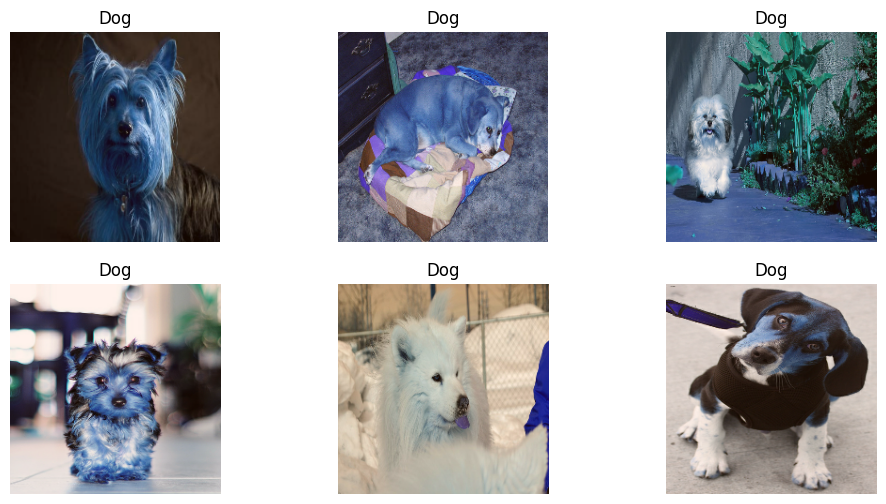

In [28]:
show_batch(train)

In [29]:
import collections
counter = collections.Counter()
for _, y in train.unbatch():  # sample to be quick
    counter[int(y)] += 1
print("Sampled species counts:", counter, "->", {species_names[k]: v for k, v in counter.items()})

Sampled species counts: Counter({1: 2132, 0: 996}) -> {'Dog': 2132, 'Cat': 996}


## Label Counts

Train set: {'Dog': 2132, 'Cat': 996}
Validation set: {'Dog': 360, 'Cat': 192}
Test set: {'Dog': 2486, 'Cat': 1183}


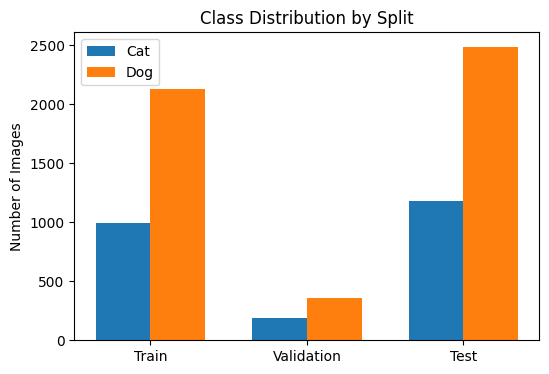

In [30]:
def count_classes(ds, name):
    counter = collections.Counter()
    for _, y in ds.unbatch():
        counter[int(y)] += 1
    print(f"{name} set:", {species_names[k].capitalize(): v for k, v in counter.items()})
    return counter  # <-- return added

train_counts = count_classes(train, "Train")
val_counts = count_classes(val, "Validation")
test_counts = count_classes(test, "Test")

species_names = ds_info.features['species'].names

# Extract counts
splits = ['Train', 'Validation', 'Test']
cat_counts = [train_counts.get(0, 0), val_counts.get(0, 0), test_counts.get(0, 0)]
dog_counts = [train_counts.get(1, 0), val_counts.get(1, 0), test_counts.get(1, 0)]

# Plot
x = range(len(splits))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar([i - width/2 for i in x], cat_counts, width, label='Cat')
plt.bar([i + width/2 for i in x], dog_counts, width, label='Dog')
plt.xticks(x, splits)
plt.ylabel('Number of Images')
plt.title('Class Distribution by Split')
plt.legend()
plt.show()

## Why VGG16 and its preprocessing

VGG16 is a classic ImageNet‑pretrained model that expects 224×224 RGB inputs and specific channel preprocessing via vgg16.preprocess_input, making it simple and reliable for transfer learning on small to medium datasets.​
The standard transfer learning workflow is to freeze the pretrained convolutional base, train a lightweight classification head, then unfreeze the upper convolution blocks for low‑LR fine‑tuning to adapt features to the task.

In [31]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

In [32]:
base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base.trainable = False

- Loads VGG16 pretrained on ImageNet.

- include_top=False → excludes the final classifier layers, leaving only convolutional feature extractor.

- base.trainable = False → freeze the weights so training doesn’t modify pretrained features initially.

In [33]:
data_aug = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

- Adds data augmentation to reduce overfitting:

  - Random horizontal flip

  - Random rotation (up to ±10%)

  - Random zoom

In [34]:
inputs = layers.Input(shape=(224,224,3))
x = data_aug(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

- inputs → placeholder for 224×224 RGB images.

- Pass through augmentation, then VGG16 backbone.

- GlobalAveragePooling2D → converts convolutional feature maps into a 1D vector.

- Dropout(0.2) → prevents overfitting by randomly zeroing 20% of neurons.

- Dense(1, activation='sigmoid') → outputs a probability for dog vs cat.

- model → complete Keras Model object.

In [35]:
model.compile(optimizer=optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

- Optimizer → Adam with learning rate 0.001.

- Loss → binary crossentropy (since it’s a 2-class problem).

- Metrics → track accuracy during training.

## Model Training

In [36]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
ckpt = tf.keras.callbacks.ModelCheckpoint('vgg16_cats_dogs.keras', monitor='val_accuracy', mode='max', save_best_only=True)

history = model.fit(train, validation_data=val, epochs=20, callbacks=[early, ckpt], verbose=1)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.6683 - loss: 1.6448 - val_accuracy: 0.9293 - val_loss: 0.2191
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.9033 - loss: 0.3315 - val_accuracy: 0.9692 - val_loss: 0.1161
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.9260 - loss: 0.2161 - val_accuracy: 0.9710 - val_loss: 0.0689
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.9345 - loss: 0.1966 - val_accuracy: 0.9746 - val_loss: 0.0554
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.9520 - loss: 0.1330 - val_accuracy: 0.9801 - val_loss: 0.0516
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.9521 - loss: 0.1256 - val_accuracy: 0.9764 - val_loss: 0.0405
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.9686 - loss: 0.0906 - val_accuracy: 0.9837 - val_loss: 0.0375
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step - accuracy: 0.9665 - loss: 0.1078 - val_accu

- EarlyStopping: stops training if validation loss doesn’t improve for 3 epochs.

- ModelCheckpoint: saves the model weights with the best validation accuracy.

- history stores loss and accuracy per epoch for both train and validation sets.

**Quick guidance on reading curves**
- Healthy learning shows training and validation loss both decreasing, with validation accuracy rising and staying close to training accuracy across epochs.​

- If validation loss rises while training loss keeps falling, that indicates overfitting; consider EarlyStopping or data augmentation/fine‑tuning adjustments.

## Model Evaluation

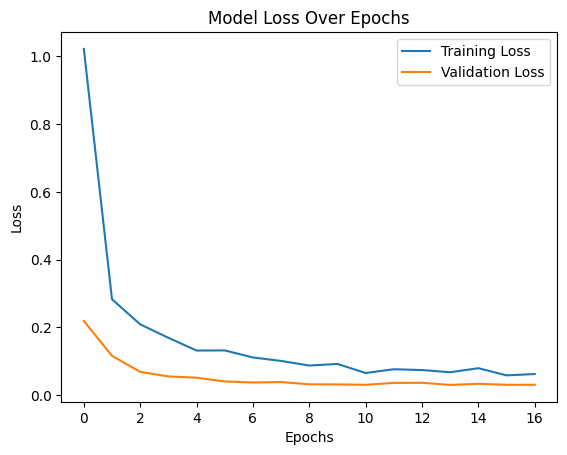

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss Over Epochs')     # Add a title
plt.xlabel('Epochs')                    # Label for x-axis
plt.ylabel('Loss')                      # Label for y-axis
plt.legend()                            # Show the legend
plt.show()

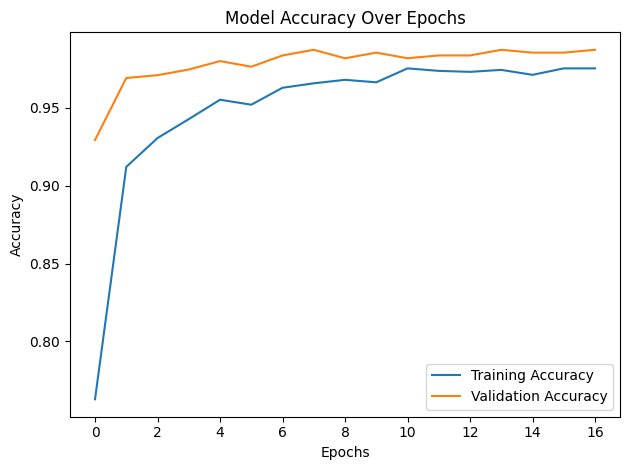

In [38]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [39]:
# Load the trained model
best_model = tf.keras.models.load_model('vgg16_cats_dogs.keras')

test_loss, test_acc = best_model.evaluate(test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.9835 - loss: 0.0576
Test Loss: 0.0632
Test Accuracy: 0.9823


## Model Testing

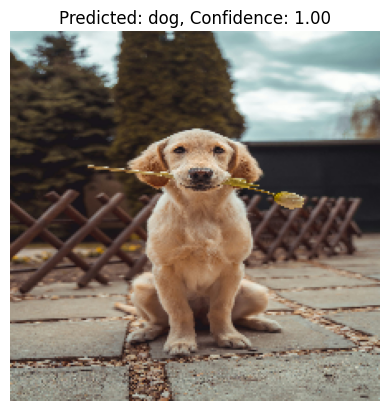

In [41]:
# Load the trained model
best_model = tf.keras.models.load_model('vgg16_cats_dogs.keras')

# Prediction function
def predict_image(path):
    # Load and resize image
    img = load_img(path, target_size=(224,224))
    x = img_to_array(img)[None, ...]  # add batch dimension
    x = tf.keras.applications.vgg16.preprocess_input(x)

    # Predict probability
    p = best_model.predict(x, verbose=0)[0][0]
    label = 'dog' if p >= 0.5 else 'cat'
    confidence = p if p >= 0.5 else 1-p

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label}, Confidence: {confidence:.2f}")
    plt.show()

    return label, float(confidence)

# --- Type your image path here ---
image_path = '/content/image2.jpg'  # replace with your image path
label, conf = predict_image(image_path)

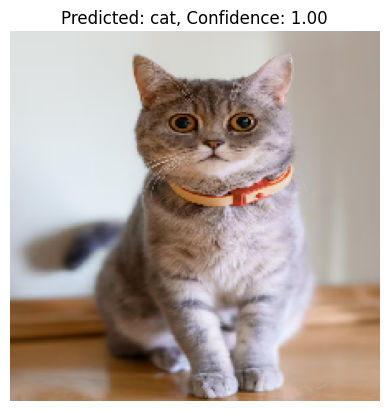

In [43]:
# Prediction function
def predict_image(path):
    # Load and resize image
    img = load_img(path, target_size=(224,224))
    x = img_to_array(img)[None, ...]  # add batch dimension
    x = tf.keras.applications.vgg16.preprocess_input(x)

    # Predict probability
    p = best_model.predict(x, verbose=0)[0][0]
    label = 'dog' if p >= 0.5 else 'cat'
    confidence = p if p >= 0.5 else 1-p

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label}, Confidence: {confidence:.2f}")
    plt.show()

    return label, float(confidence)

# --- Type your image path here ---
image_path = '/content/image1.jpg'  # replace with your image path
label, conf = predict_image(image_path)